In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from math import floor

from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
if os.path.exists("./tensor_y.npy"):
    os.remove("./tensor_y.npy")
if os.path.exists("./tensor_x.npy"):
    os.remove("./tensor_x.npy")
if os.path.exists("./val_tensor_x.npy"):
    os.remove("./val_tensor_x.npy")
if os.path.exists("./val_tensor_y.npy"):
    os.remove("./val_tensor_y.npy")
if os.path.exists("./test_tensor_y.npy"):
    os.remove("./test_tensor_y.npy")
if os.path.exists("./test_tensor_x.npy"):
    os.remove("./test_tensor_x.npy")

In [18]:
epochs = 50
batch_size = 16
lr = 1e-3

alpha = 0.1

resize_height = 256
resize_width = 256

ratio = 4
train_val_split_perc = 0.9
val_test_split_perc = 0.5

In [4]:
def preprocessing(path, ratio, resize_height, resize_width):
    y = tf.keras.utils.load_img(path)
    y = tf.keras.utils.img_to_array(y)
    y = tf.image.resize(y,
                        [resize_height, resize_width],
                        'bicubic',
                        antialias=True,
                        )
    height, width, _ = y.shape
    x = tf.image.resize(y,
                        [height // ratio, width // ratio],
                        'bicubic',
                        antialias=True,
                        )
    x = x / 255.0
    y = y / 255.0
    return x, y

In [5]:
img_paths = []
val_img_paths = []
test_img_paths = []
for dirname, _, filenames in os.walk('ISR_DIV2K/DIV2K_train_HR'):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('ISR_DIV2K/DIV2K_valid_HR'):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('urban100'):
    for filename in filenames:
        test_img_paths.append(os.path.join(dirname, filename))
        
print('Dataset dimension: ', len(img_paths))

val_img_paths = img_paths[floor(len(img_paths) * train_val_split_perc):]
img_paths = img_paths[:floor(len(img_paths) * train_val_split_perc)]

print('Training: ', len(img_paths))

print('Test dataset dimension: ', len(test_img_paths))

Dataset dimension:  900
Training:  810
Test dataset dimension:  100


In [6]:
if not (os.path.exists('./tensor_x.npy')) or not (os.path.exists('./tensor_y.npy')):

    img_lr = []
    img_hr = []

    for i in tqdm(range(len(img_paths))):
        x, y = preprocessing(img_paths[i], ratio, resize_height, resize_width)
        img_lr.append(x)
        img_hr.append(y)
    
    tensor_x = tf.convert_to_tensor(img_lr).numpy()
    tensor_y = tf.convert_to_tensor(img_hr).numpy()
    tensor_x.shape

    np.save('./tensor_x.npy', tensor_x)
    np.save('./tensor_y.npy', tensor_y)
    img_lr = tensor_x
    img_hr = tensor_y
else:
    img_lr = np.load('./tensor_x.npy')
    img_hr = np.load('./tensor_y.npy')


100%|████████████████████████████████████████████████████████████████████████████████| 810/810 [02:36<00:00,  5.16it/s]


In [7]:
if not (os.path.exists('./val_tensor_x.npy')) or not (os.path.exists('./val_tensor_y.npy')):

    val_img_lr = []
    val_img_hr = []

    for i in tqdm(range(len(val_img_paths))):
        x, y = preprocessing(val_img_paths[i], ratio, resize_height * 2, resize_width * 2)
        val_img_lr.append(x)
        val_img_hr.append(y)
    
    val_tensor_x = tf.convert_to_tensor(val_img_lr).numpy()
    val_tensor_y = tf.convert_to_tensor(val_img_hr).numpy()

    np.save('./val_tensor_x.npy', val_tensor_x)
    np.save('./val_tensor_y.npy', val_tensor_y)
    val_img_lr = tensor_x
    val_img_hr = tensor_y
else:
    val_img_lr = np.load('./val_tensor_x.npy')
    val_img_hr = np.load('./val_tensor_y.npy')

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.55it/s]


In [20]:
if not (os.path.exists('./test_tensor_x.npy')) or not (os.path.exists('./test_tensor_y.npy')):

    test_img_lr = []
    test_img_hr = []

    for i in tqdm(range(len(test_img_paths))):
        x, y = preprocessing(test_img_paths[i], ratio, resize_height, resize_width)
        test_img_lr.append(x)
        test_img_hr.append(y)
    
    tensor_x = tf.convert_to_tensor(test_img_lr).numpy()
    tensor_y = tf.convert_to_tensor(test_img_hr).numpy()
    tensor_x.shape

    np.save('./test_tensor_x.npy', tensor_x)
    np.save('./test_tensor_y.npy', tensor_y)
    test_img_lr = tensor_x
    test_img_hr = tensor_y
else:
    test_img_lr = np.load('./test_tensor_x.npy')
    test_img_hr = np.load('./test_tensor_y.npy')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.78it/s]


In [10]:
def residual_block(x, num_filters):
    # Convolutional layers with batch normalization
    res = layers.Conv2D(num_filters, kernel_size=3, padding='same')(x)
    res = layers.Activation('relu')(res)
    res = layers.Conv2D(num_filters, kernel_size=3, padding='same')(res)
    res = layers.BatchNormalization()(res)

    # Adjust the number of channels and spatial dimensions in the input tensor to match the output tensor
    inputs_adjusted = layers.Conv2D(num_filters, kernel_size=1, padding='same')(x)

    # Skip connection
    res = layers.Add()([res, inputs_adjusted])
    return res

In [14]:
def edsr_model(scale_factor=2, num_filters=64, num_res_blocks=8, input_shape=(64, 64, 3), output_shape=(128, 128, 3)):
    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Feature extraction
    x = layers.Conv2D(num_filters, kernel_size=3, padding='same')(inputs)
    x = layers.Activation('relu')(x)

    # Residual blocks
    for _ in range(num_res_blocks):
        x = residual_block(x, num_filters)

    # Feature reconstruction
    x = layers.Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, layers.Conv2D(num_filters, kernel_size=1, padding='same')(inputs)])

    # First Upsampling
    x = layers.UpSampling2D(size=(scale_factor, scale_factor), interpolation='bilinear')(x)

    # Second Upsampling
    x = layers.Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = layers.UpSampling2D(size=(scale_factor, scale_factor), interpolation='bilinear')(x)

    # Output layer
    outputs = layers.Conv2D(3, kernel_size=3, padding='same')(x)

    # Create model
    model = models.Model(inputs, outputs, name='edsr')
    return model

# Instantiate the model
input_shape = (64, 64, 3)
edsr = edsr_model(scale_factor=2, num_filters=64, num_res_blocks=8, input_shape=input_shape)

# Print the model summary
edsr.summary()

Model: "edsr"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 64, 64, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 activation_9 (Activation)      (None, 64, 64, 64)   0           ['conv2d_28[0][0]']              
                                                                                                  
 conv2d_29 (Conv2D)             (None, 64, 64, 64)   36928       ['activation_9[0][0]']           
                                                                                               

 conv2d_45 (Conv2D)             (None, 64, 64, 64)   36928       ['activation_15[0][0]']          
                                                                                                  
 batch_normalization_13 (BatchN  (None, 64, 64, 64)  256         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_46 (Conv2D)             (None, 64, 64, 64)   4160        ['add_13[0][0]']                 
                                                                                                  
 add_14 (Add)                   (None, 64, 64, 64)   0           ['batch_normalization_13[0][0]', 
                                                                  'conv2d_46[0][0]']              
                                                                                                  
 conv2d_47

In [15]:
edsr.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=MeanSquaredError())

In [16]:
print("img_lr",img_lr.shape)
print("img_hr",img_hr.shape)


img_lr (810, 64, 64, 3)
img_hr (810, 256, 256, 3)


In [19]:

edsr_history=edsr.fit(img_lr, img_hr, epochs=epochs, batch_size=16, validation_data=(val_img_lr, val_img_hr))
#edsr_history=edsr.fit(img_lr, img_hr_resized, epochs=10, batch_size=16, validation_data=(val_img_lr, val_img_hr_resized))


Epoch 1/50
51/51 [==============================] - 509s 10s/step - loss: 0.0342 - val_loss: 0.0515
Epoch 2/50
51/51 [==============================] - 506s 10s/step - loss: 0.0250 - val_loss: 0.0430
Epoch 3/50
51/51 [==============================] - 506s 10s/step - loss: 0.0215 - val_loss: 0.0359
Epoch 4/50
51/51 [==============================] - 505s 10s/step - loss: 0.0172 - val_loss: 0.0301
Epoch 5/50
51/51 [==============================] - 509s 10s/step - loss: 0.0158 - val_loss: 0.0254
Epoch 6/50
51/51 [==============================] - 507s 10s/step - loss: 0.0167 - val_loss: 0.0217
Epoch 7/50
51/51 [==============================] - 505s 10s/step - loss: 0.0148 - val_loss: 0.0179
Epoch 8/50
51/51 [==============================] - 507s 10s/step - loss: 0.0130 - val_loss: 0.0139
Epoch 9/50
51/51 [==============================] - 506s 10s/step - loss: 0.0133 - val_loss: 0.0133
Epoch 10/50
51/51 [==============================] - 505s 10s/step - loss: 0.0110 - val_loss: 0.0106

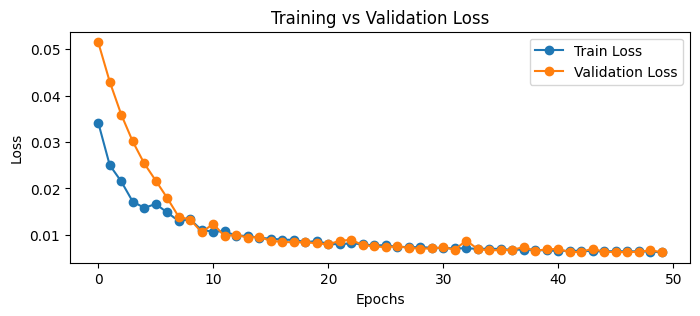

In [25]:
plt.figure(figsize=(8, 3))
plt.plot(edsr_history.history['loss'], label='Train Loss', marker='o')
plt.plot(edsr_history.history['val_loss'], label='Validation Loss', marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
# Evaluate the model on the test set
edsr_loss = edsr.evaluate(test_low_res, test_high_res)
print(f'Test Loss: {edsr_loss}')

26/26 [==============================] - 59s 2s/step - loss: 0.0012
Test Loss: 0.0011582364095374942


In [26]:
edsr_predictions = edsr.predict(test_img_lr)

4/4 [==============================] - 7s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


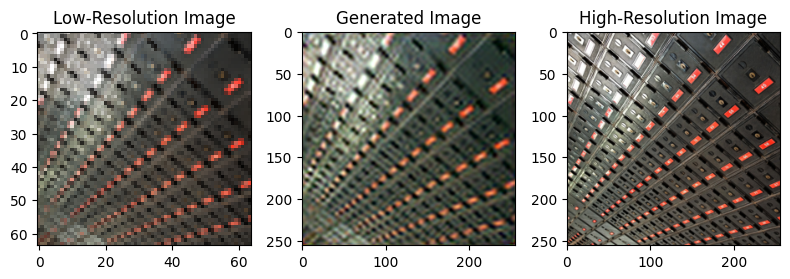

In [27]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 3, 1)
plt.imshow(test_img_lr[5])
plt.title('Low-Resolution Image')

plt.subplot(1, 3, 2)
plt.imshow(edsr_predictions[5])
plt.title('Generated Image')

plt.subplot(1, 3, 3)
plt.imshow(test_img_hr[5])
plt.title('High-Resolution Image')

plt.tight_layout()

plt.show()

In [37]:
from skimage.metrics import peak_signal_noise_ratio as psnr


def calculate_psnr(img1, img2, data_range=None):
    psnr_value = psnr(img1, img2, data_range=data_range)
    return psnr_value

psnr_value = calculate_psnr(test_img_hr[5], edsr_predictions[5], data_range=255)

print(f"PSNR: {psnr_value} dB")

PSNR: 68.42902626976812 dB
